# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [2]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/zakariaabou/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

fatal: destination path 'exam_2025_session2' already exists and is not an empty directory.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


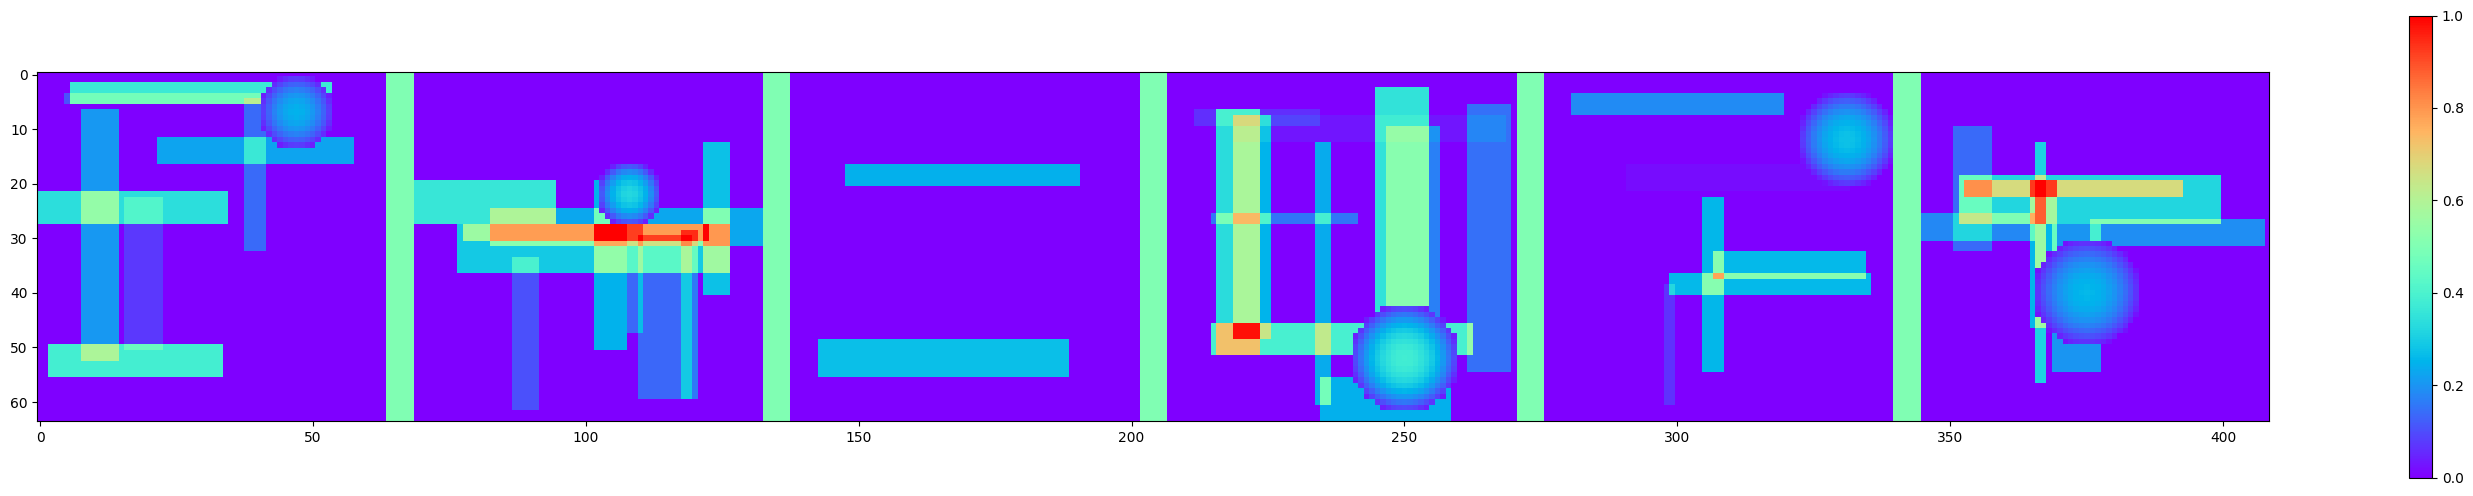

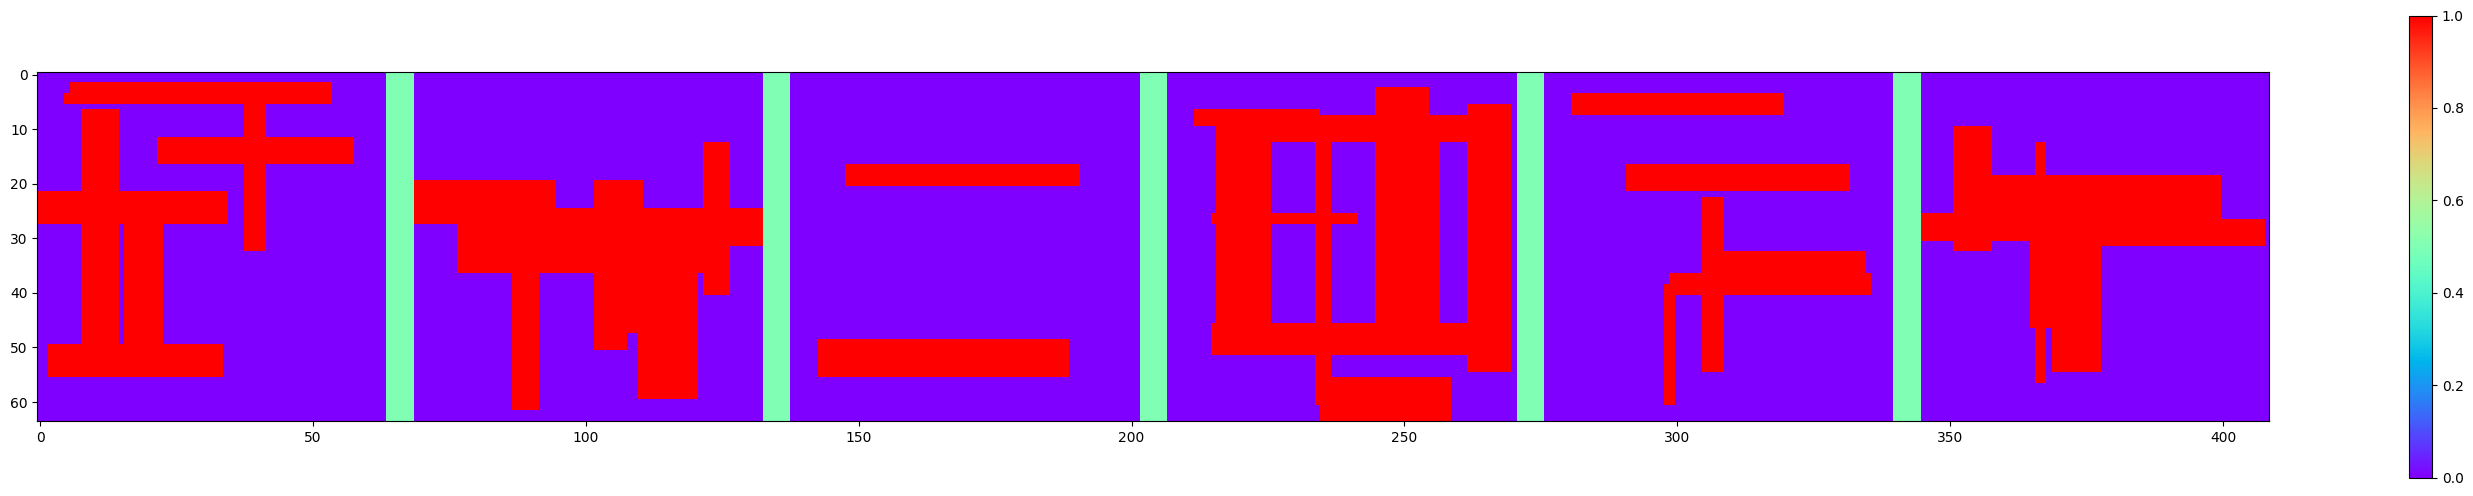

In [3]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

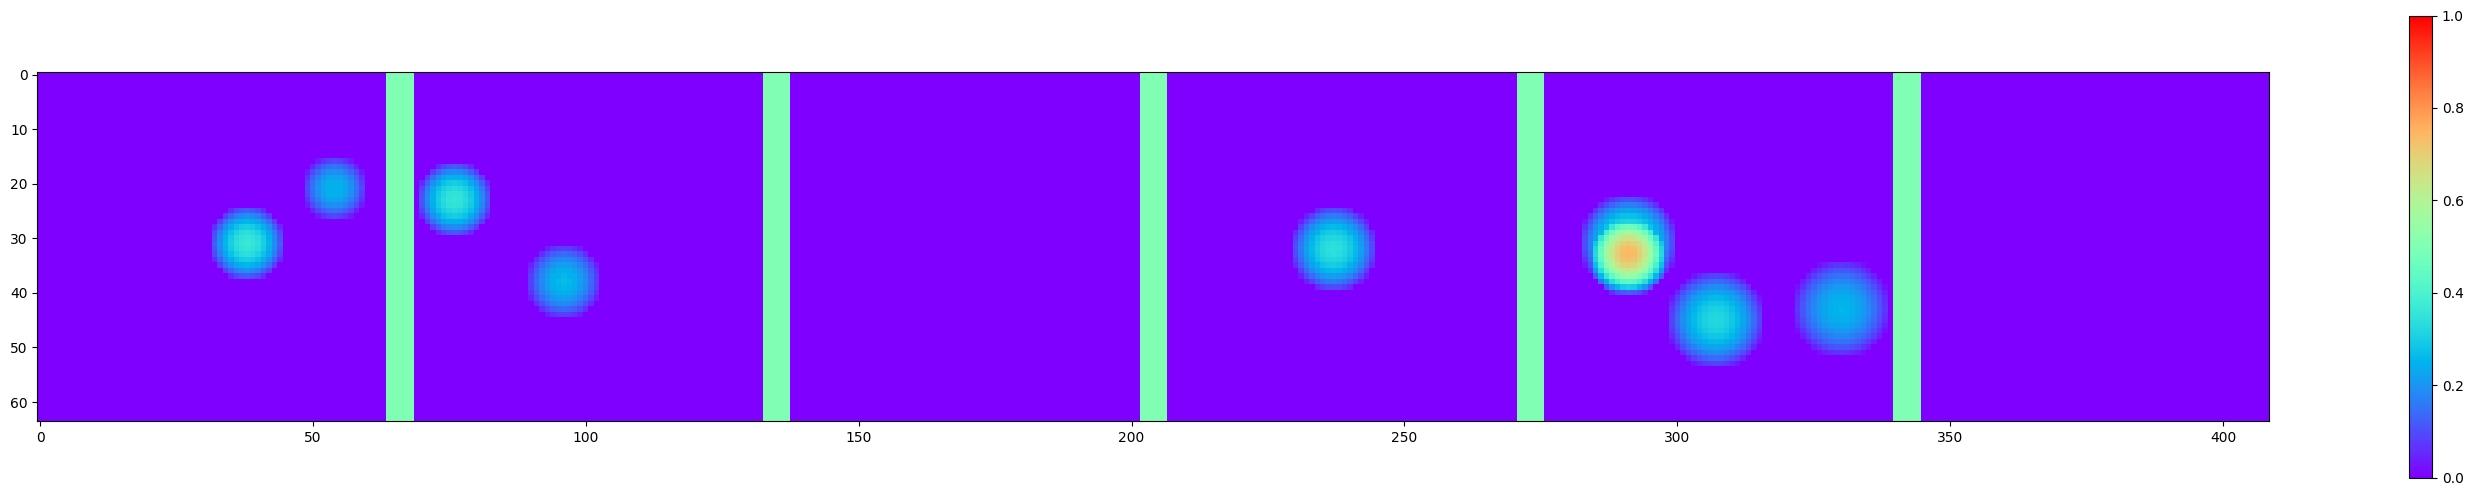

In [4]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

La supervision faible consiste à apprendre à partir de données partiellement étiquetées, bruitées ou imprécises. Dans cet exercice, la segmentation doit être effectuée sur des images corrompues (avec des disques ajoutés comme bruit), sans disposer d'une cible idéale précise. Cela correspond à un cas de supervision faible, car la cible idéale (sans bruit) n'est pas disponible, et le modèle doit apprendre à partir des données corrompues.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

<ipython-input-7-7476cb989ef8>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
<ipython-input-7-7476cb989ef8>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ideal_targets = torch.tensor(ideal_targets, dtype=torch.float32).to(device)


Epoch 1/50, Loss: 0.11656170338392258
Epoch 2/50, Loss: 0.062210813164711
Epoch 3/50, Loss: 0.09088309109210968
Epoch 4/50, Loss: 0.04189859330654144
Epoch 5/50, Loss: 0.023533951491117477
Epoch 6/50, Loss: 0.026228301227092743
Epoch 7/50, Loss: 0.03993847966194153
Epoch 8/50, Loss: 0.027492064982652664
Epoch 9/50, Loss: 0.03887561336159706
Epoch 10/50, Loss: 0.015194260515272617
Epoch 11/50, Loss: 0.022368064150214195
Epoch 12/50, Loss: 0.04439245164394379
Epoch 13/50, Loss: 0.020438838750123978
Epoch 14/50, Loss: 0.00846119225025177
Epoch 15/50, Loss: 0.019970053806900978
Epoch 16/50, Loss: 0.012644276954233646
Epoch 17/50, Loss: 0.018261045217514038
Epoch 18/50, Loss: 0.01625247672200203
Epoch 19/50, Loss: 0.03994452953338623
Epoch 20/50, Loss: 0.055038876831531525
Epoch 21/50, Loss: 0.019805550575256348
Epoch 22/50, Loss: 0.0077729253098368645
Epoch 23/50, Loss: 0.02635969966650009
Epoch 24/50, Loss: 0.011193705722689629
Epoch 25/50, Loss: 0.03568308800458908
Epoch 26/50, Loss: 0.0

<ipython-input-7-7476cb989ef8>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

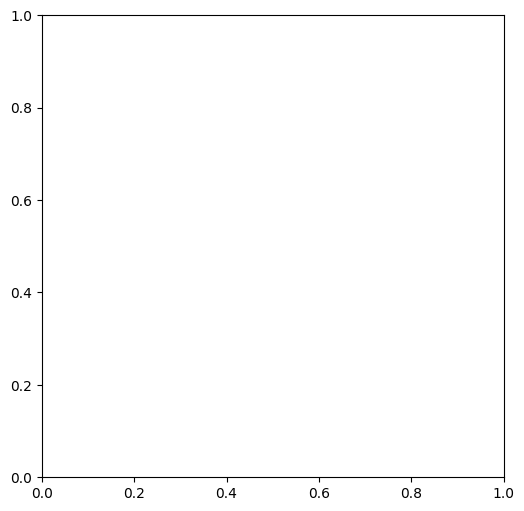

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Génération des données d'entraînement
inputs, ideal_targets = gen_dr(1000)  # Générer 1000 images pour l'entraînement
inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
ideal_targets = torch.tensor(ideal_targets, dtype=torch.float32).to(device)

# Création du DataLoader
dataset = TensorDataset(inputs, ideal_targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Définition du modèle UNet et déplacement vers le GPU
model = UNet(n_channels=1, n_classes=1).to(device)  # 1 canal d'entrée, 1 classe de sortie

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 50
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)  # Déplacement vers le GPU
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

<ipython-input-10-7a7ff8405a57>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)


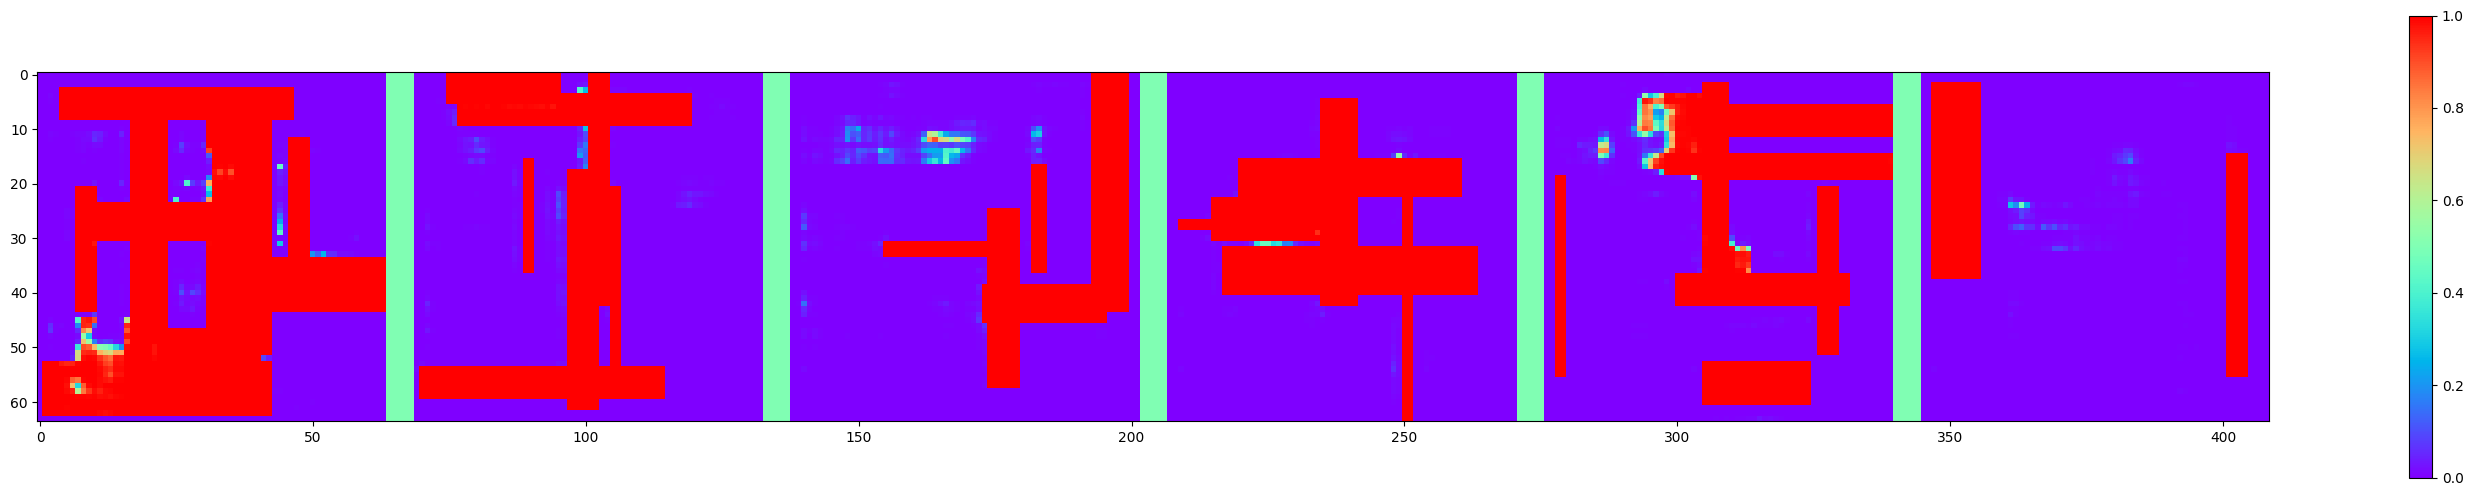

In [10]:
# Visualisation des résultats après entraînement
test_inputs, _ = gen_dr(6)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)
with torch.no_grad():
    predicted = model(test_inputs)
    predicted = torch.sigmoid(predicted)  # Convertir les logits en probabilités

# Déplacer les résultats du GPU vers le CPU et convertir en tensor PyTorch
predicted = predicted.cpu()  # Déplacer vers le CPU sans la conversion en NumPy

# Affichage des résultats
fig = plt.figure(figsize=(36, 6))
voir_batch2D(predicted, 6, fig, k=0, min_scale=0, max_scale=1)

\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([4.7044, 2.9630, 5.7432, 5.4055, 6.3139, 6.3760])


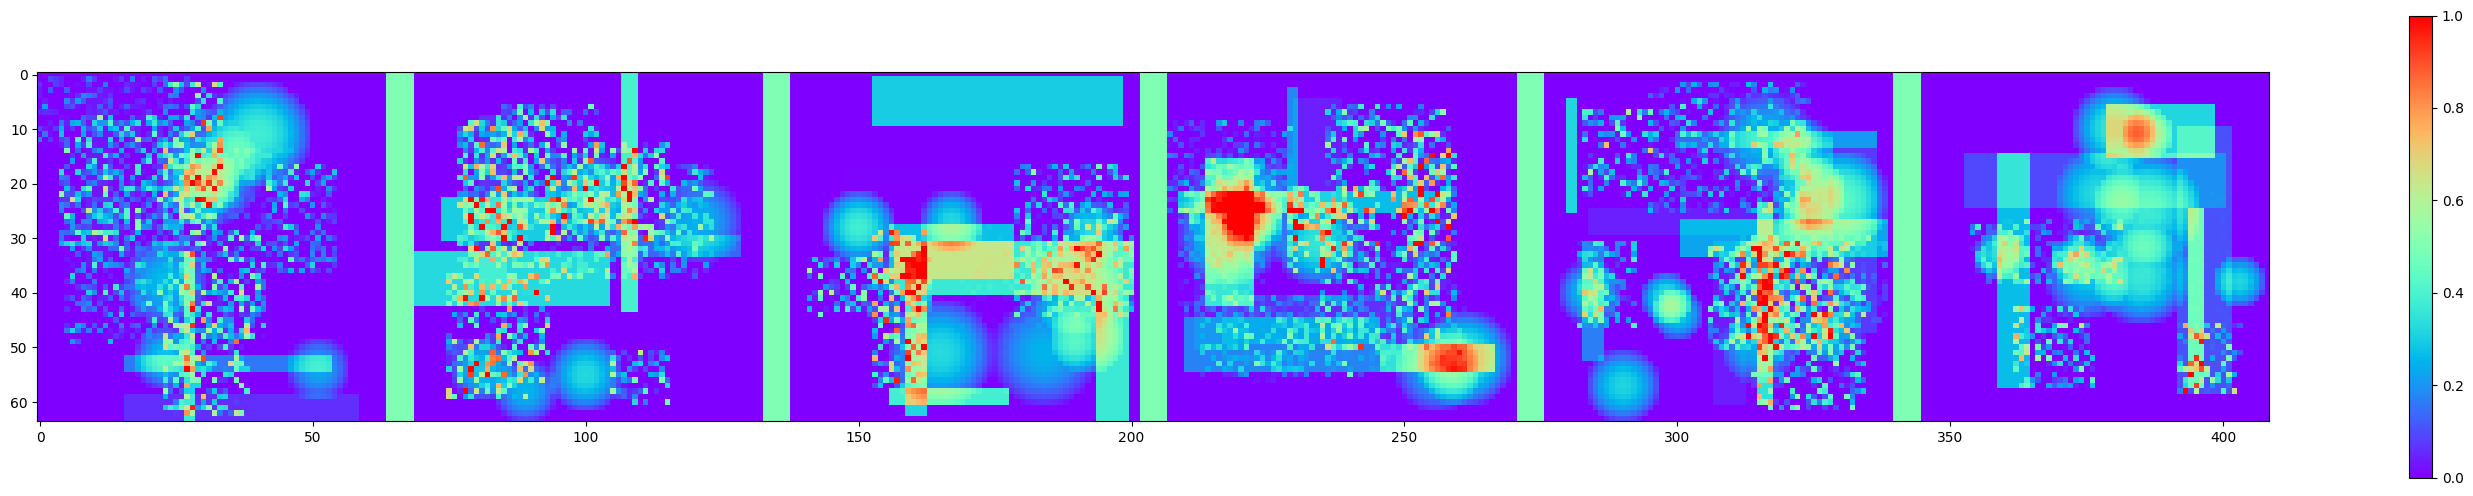

tensor([3.5727, 2.5430, 6.5815, 6.4280, 6.3294, 4.9601])


In [11]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Génération des données
inputs, targets = gen_ex2(1000)  # Générer 1000 échantillons
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# Création du DataLoader
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [16]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement du modèle ResNet18
model = resnet18(pretrained=False)

# Modifier la première couche pour accepter 1 canal (image en niveaux de gris)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modifier la dernière couche pour la régression
model.fc = nn.Linear(model.fc.in_features, 1)

# Déplacer le modèle vers le périphérique approprié (GPU ou CPU)
model = model.to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.L1Loss()  # Loss pour la médiane
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 20
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Déplacer les données d'entrée et les cibles vers le périphérique
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        batch_targets = batch_targets.view(batch_targets.size(0), -1)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([32, 4096])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([8, 4096])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 0.37221091985702515
Epoch 2/20, Loss: 0.36309775710105896
Epoch 3/20, Loss: 0.3953147232532501
Epoch 4/20, Loss: 0.30053287744522095
Epoch 5/20, Loss: 0.3038577437400818
Epoch 6/20, Loss: 0.3239918351173401
Epoch 7/20, Loss: 0.3058214783668518
Epoch 8/20, Loss: 0.42160236835479736
Epoch 9/20, Loss: 0.3782266080379486
Epoch 10/20, Loss: 0.3822796940803528
Epoch 11/20, Loss: 0.37816953659057617
Epoch 12/20, Loss: 0.4177548289299011
Epoch 13/20, Loss: 0.3039734661579132
Epoch 14/20, Loss: 0.37592753767967224
Epoch 15/20, Loss: 0.3533856272697449
Epoch 16/20, Loss: 0.2925378084182739
Epoch 17/20, Loss: 0.2920803427696228
Epoch 18/20, Loss: 0.35777366161346436
Epoch 19/20, Loss: 0.3959483504295349
Epoch 20/20, Loss: 0.30173996090888977


**Justification de l'absence de validation :** Dans ce cas, les données sont générées de manière synthétique et ne présentent pas de risque de sur-apprentissage. Par conséquent, une étape de validation n'est pas nécessaire.

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement du modèle ResNet18
model = resnet18(pretrained=False)

# Modifier la première couche pour accepter 1 canal (image en niveaux de gris)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modifier la dernière couche pour prédire 3 sorties (premier quartile, médiane, troisième quartile)
model.fc = nn.Linear(model.fc.in_features, 3)

# Déplacer le modèle vers le périphérique (GPU ou CPU)
model = model.to(device)

# Définition de la fonction de perte pour la régression quantile
def quantile_loss(outputs, targets, quantiles=[0.25, 0.5, 0.75]):
    losses = []
    for i, q in enumerate(quantiles):
        errors = targets - outputs[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

# Fonction pour calculer les quantiles
def calculate_quantiles(tensor, quantiles=[0.25, 0.5, 0.75]):
    quantiles_values = []
    for q in quantiles:
        quantiles_values.append(torch.quantile(tensor.view(tensor.size(0), -1), q, dim=1))
    return torch.stack(quantiles_values, dim=1).T  # (batch_size, 3)

# Définition de l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 20
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Déplacer les données d'entrée et les cibles vers le périphérique
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        # Calculer les quantiles des cibles si elles sont sous forme d'images
        batch_targets = calculate_quantiles(batch_targets)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = quantile_loss(outputs, batch_targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/20, Loss: 0.4784550666809082
Epoch 2/20, Loss: 0.3872854709625244
Epoch 3/20, Loss: 0.40646788477897644
Epoch 4/20, Loss: 0.5278171896934509
Epoch 5/20, Loss: 0.40595802664756775
Epoch 6/20, Loss: 0.4213812053203583
Epoch 7/20, Loss: 0.3289443552494049
Epoch 8/20, Loss: 0.37125545740127563
Epoch 9/20, Loss: 0.32417458295822144
Epoch 10/20, Loss: 0.3557727336883545
Epoch 11/20, Loss: 0.3764399290084839
Epoch 12/20, Loss: 0.36337190866470337
Epoch 13/20, Loss: 0.41750025749206543
Epoch 14/20, Loss: 0.46470487117767334
Epoch 15/20, Loss: 0.36310702562332153
Epoch 16/20, Loss: 0.4139518141746521
Epoch 17/20, Loss: 0.43681466579437256
Epoch 18/20, Loss: 0.35315895080566406
Epoch 19/20, Loss: 0.4003976285457611
Epoch 20/20, Loss: 0.3680543303489685


**Fonction de coût utilisée :** La fonction de perte utilisée est la perte de régression quantile, qui est adaptée pour prédire les quantiles (premier quartile, médiane, troisième quartile).

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

In [24]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Génération d'un batch de test
test_inputs, test_targets = gen_ex2(64)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)  # Déplacer test_inputs vers le périphérique
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)  # Déplacer test_targets vers le périphérique

# Prédiction des quantiles
with torch.no_grad():
    outputs = model(test_inputs)
    q1, q2, q3 = outputs[:, 0], outputs[:, 1], outputs[:, 2]

# Calcul des écarts interquartiles
iqr = q3 - q1
print("Écarts interquartiles :", iqr)

tensor([3.1241, 5.5749, 6.0468, 6.8242, 7.1107, 5.1440, 4.8294, 6.6838, 5.9747,
        1.5155, 1.8380, 5.6490, 5.0034, 2.6500, 6.3252, 3.5670, 4.5908, 2.2840,
        6.1354, 5.5858, 3.4445, 3.9081, 5.6769, 7.6849, 2.4390, 6.5142, 6.4195,
        5.1221, 8.9217, 5.7742, 1.9630, 3.5676, 2.6493, 6.1789, 6.7194, 6.5497,
        3.7675, 4.8862, 9.5458, 5.2630, 8.2731, 4.0533, 5.5387, 3.7981, 5.1359,
        6.3636, 8.1659, 7.0916, 3.2352, 7.2503, 4.1079, 6.2669, 5.0903, 4.8735,
        2.6795, 4.0608, 9.8680, 4.4495, 9.4328, 4.3729, 2.2269, 2.8679, 4.1052,
        4.6425])
Écarts interquartiles : tensor([0.9265, 0.4434, 0.9150, 0.8809, 0.9818, 0.7267, 0.1594, 0.9094, 0.9845,
        0.1119, 0.9487, 0.9558, 0.9322, 1.0052, 0.2951, 0.2871, 0.9636, 0.6705,
        0.9471, 0.9553, 0.9521, 0.8263, 0.8619, 0.9623, 0.9383, 0.7529, 0.9938,
        0.9475, 0.5306, 0.8851, 0.8722, 0.2477, 0.8485, 0.7494, 0.9739, 0.8353,
        0.7325, 0.4401, 0.8238, 0.7707, 0.9329, 0.9224, 0.5984, 0.6998, 0.1364,

<ipython-input-24-5342538da450>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)  # Déplacer test_inputs vers le périphérique
<ipython-input-24-5342538da450>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)  # Déplacer test_targets vers le périphérique


**Observation :** Les écarts interquartiles peuvent varier en fonction de l'image d'entrée, ce qui suggère que l'incertitude de la prédiction dépend des caractéristiques de l'image.

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

Pour tester cette hypothèse, on pourrait entraîner un modèle uniquement sur les images générées par gen_d (uniquement des disques) et évaluer ses performances sur les images de gen_ex2. Si le modèle performe bien, cela suggère que les disques sont suffisants pour prédire la sortie. Sinon, cela indique que d'autres éléments (comme les rectangles) jouent un rôle important.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

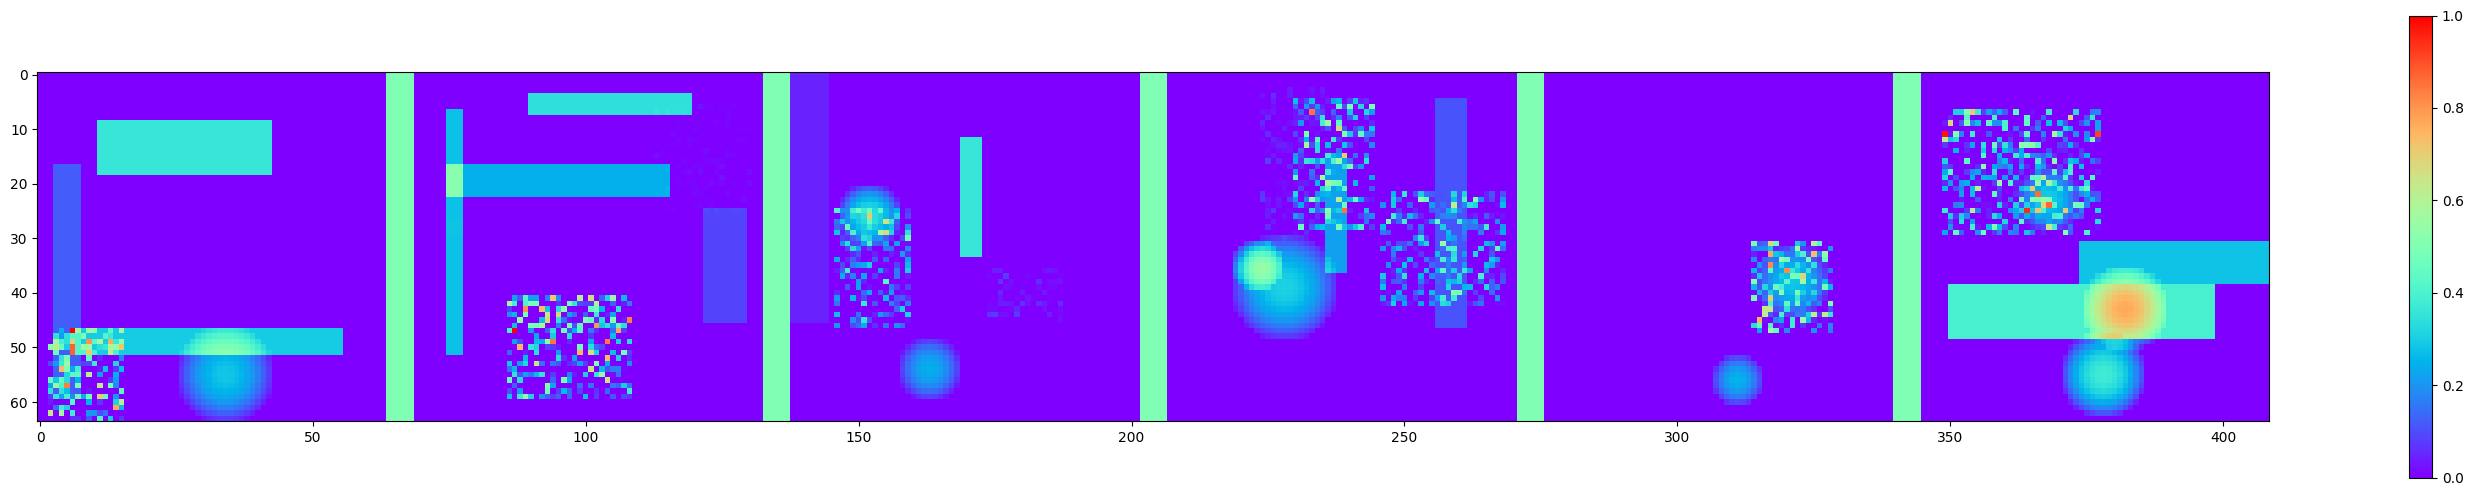

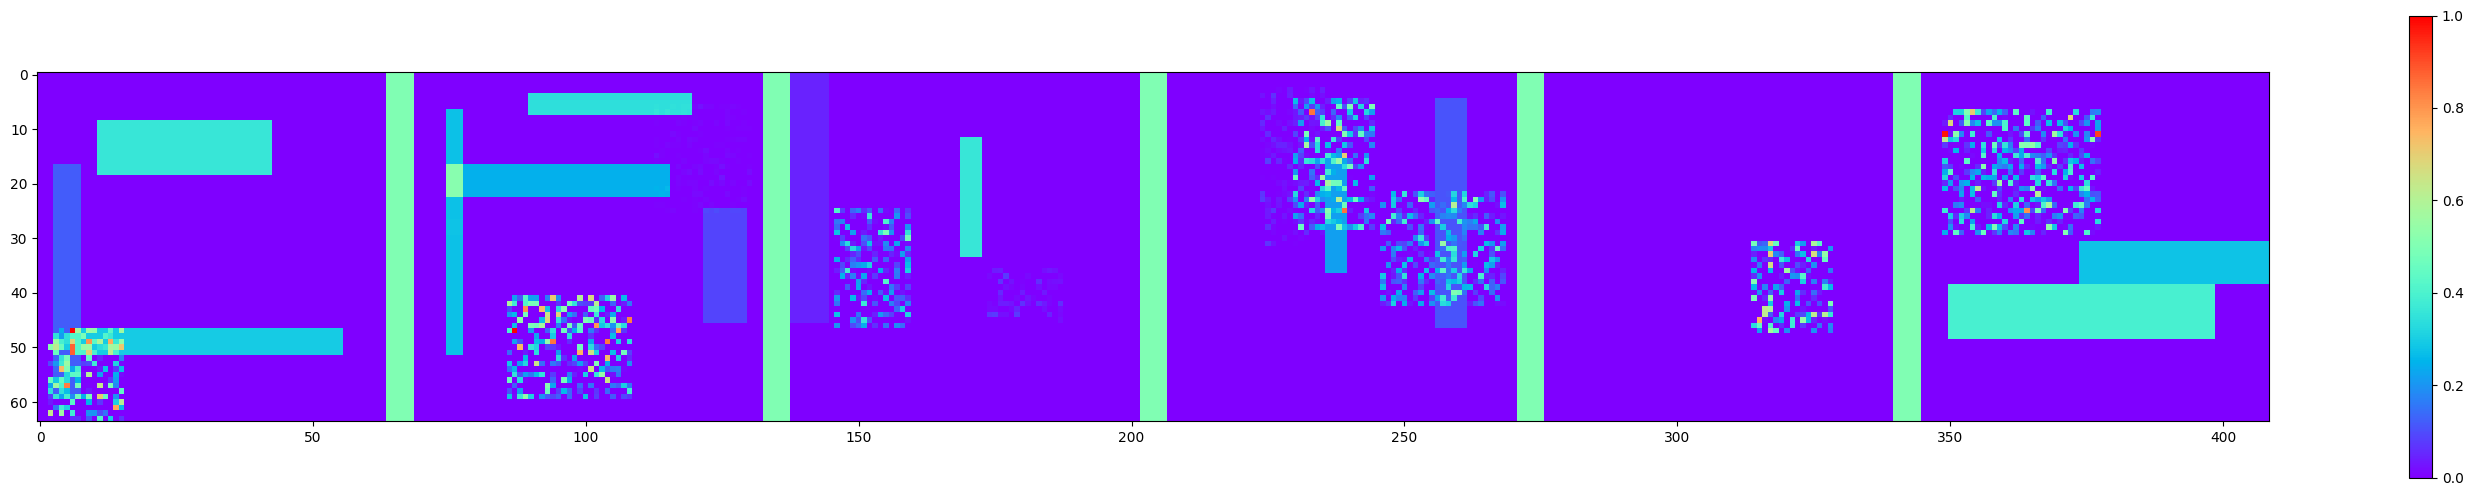

In [25]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

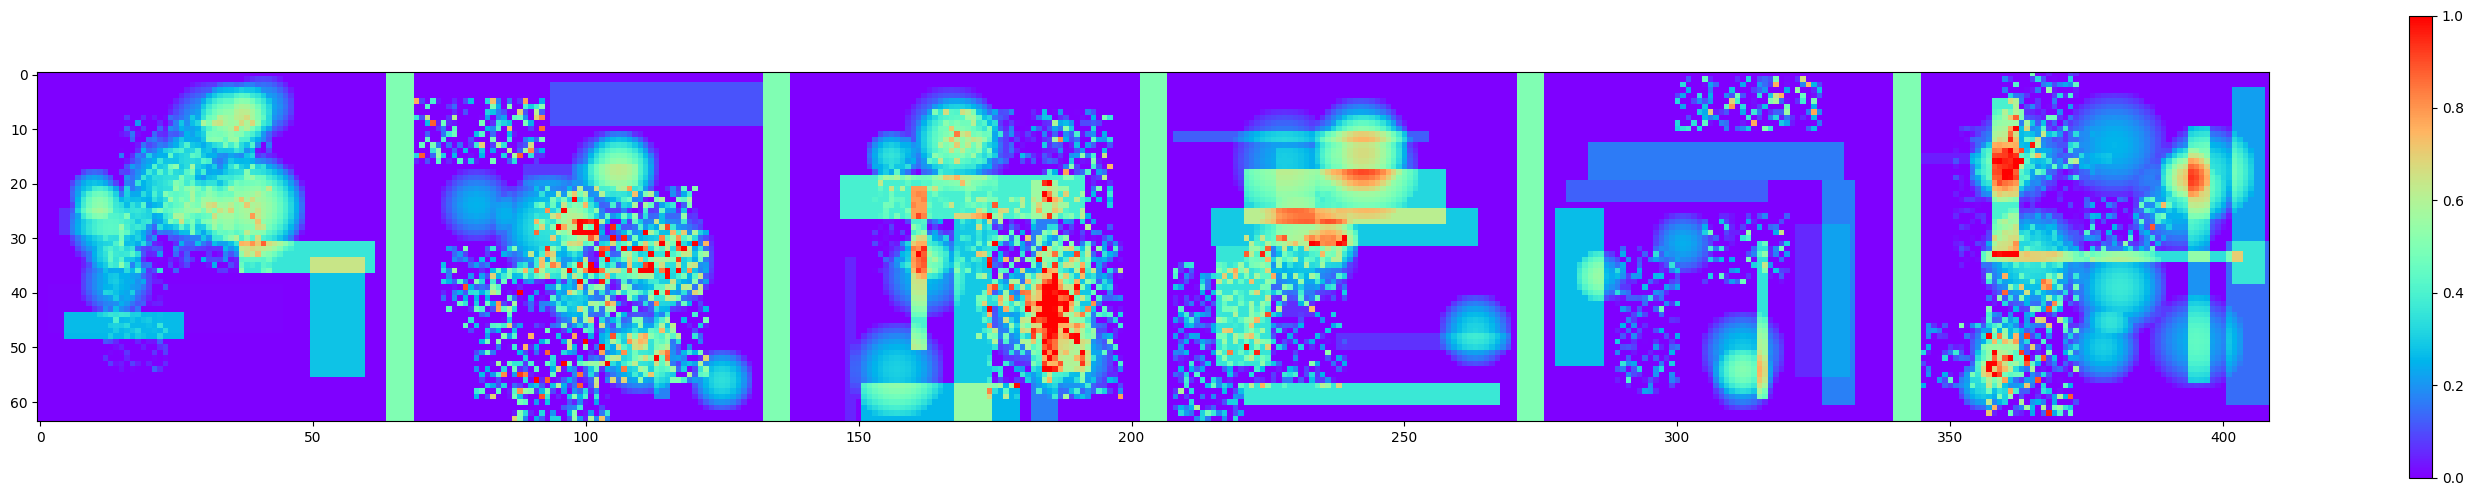

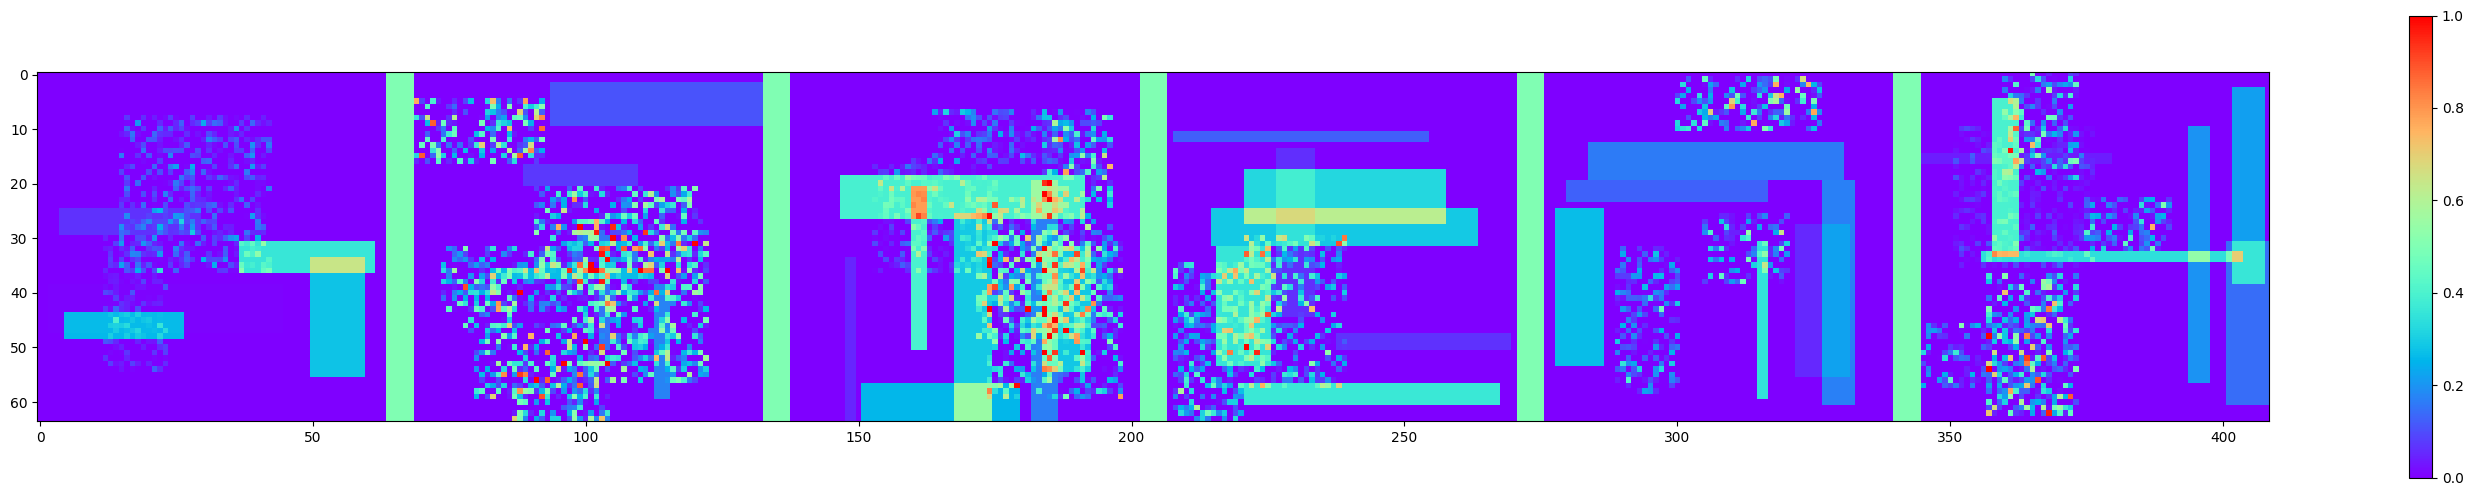

In [26]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

La domain adaptation (adaptation de domaine) est une technique utilisée pour adapter un modèle entraîné sur un domaine source (par exemple, des images avec certaines caractéristiques) à un domaine cible (des images avec des caractéristiques différentes). Dans ce problème, les données d'entraînement (gen_dr_train) et de test (gen_dr_test) ont des distributions différentes, ce qui nécessite une adaptation de domaine pour améliorer les performances sur les données de test.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Génération d'un batch d'entraînement
train_inputs, train_targets = gen_dr_train(1000)
train_inputs = torch.tensor(train_inputs, dtype=torch.float32).to(device)  # Déplacer vers le périphérique
train_targets = torch.tensor(train_targets, dtype=torch.float32).to(device)  # Déplacer vers le périphérique

# Création du DataLoader
train_dataset = TensorDataset(train_inputs, train_targets)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialisation du modèle UNet et déplacement vers le périphérique
model = UNet(n_channels=1, n_classes=1).to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 20
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in train_dataloader:
        # Déplacer les données d'entrée et les cibles vers le périphérique
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


<ipython-input-28-5ed682790bb7>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs, dtype=torch.float32).to(device)  # Déplacer vers le périphérique
<ipython-input-28-5ed682790bb7>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(train_targets, dtype=torch.float32).to(device)  # Déplacer vers le périphérique


Epoch 1/20, Loss: 0.23420822620391846
Epoch 2/20, Loss: 0.1410454511642456
Epoch 3/20, Loss: 0.1151220053434372
Epoch 4/20, Loss: 0.09134524315595627
Epoch 5/20, Loss: 0.09930574148893356
Epoch 6/20, Loss: 0.0734347254037857
Epoch 7/20, Loss: 0.08245424926280975
Epoch 8/20, Loss: 0.09438112378120422
Epoch 9/20, Loss: 0.06492672115564346
Epoch 10/20, Loss: 0.06840653717517853
Epoch 11/20, Loss: 0.06847401708364487
Epoch 12/20, Loss: 0.07032419741153717
Epoch 13/20, Loss: 0.10086258500814438
Epoch 14/20, Loss: 0.08279353380203247
Epoch 15/20, Loss: 0.09761505573987961
Epoch 16/20, Loss: 0.04999646916985512
Epoch 17/20, Loss: 0.10824170708656311
Epoch 18/20, Loss: 0.07184582948684692
Epoch 19/20, Loss: 0.08521053940057755
Epoch 20/20, Loss: 0.09502487629652023


<ipython-input-29-a9c50f45e425>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)  # Déplacer vers le périphérique
<ipython-input-29-a9c50f45e425>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)  # Déplacer vers le périphérique


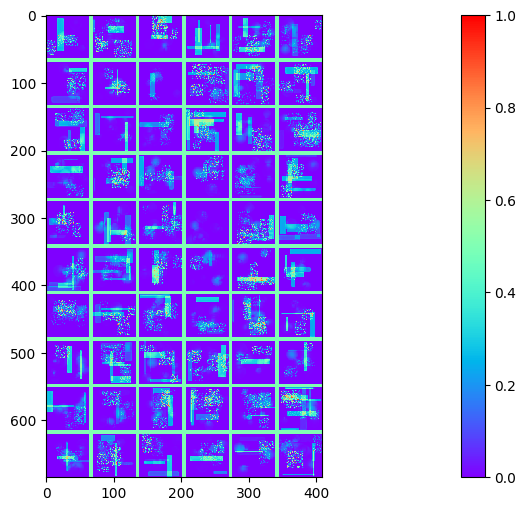

In [29]:

# Évaluation sur les données de test
test_inputs, test_targets = gen_dr_test(64)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)  # Déplacer vers le périphérique
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)  # Déplacer vers le périphérique

with torch.no_grad():
    outputs = model(test_inputs)
    outputs = torch.sigmoid(outputs)  # Appliquer une fonction sigmoïde pour obtenir des probabilités

# Affichage des résultats
fig = plt.figure(figsize=(36, 6))
voir_batch2D(outputs.cpu(), 6, fig, k=0, min_scale=0, max_scale=1)  # Déplacer vers le CPU pour affichage


Observation : Les performances sur les données de test seront probablement moins bonnes que sur les données d'entraînement en raison de la différence de distribution entre les deux ensembles.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

Une méthode simple pour améliorer les performances serait d'utiliser une technique d'adaptation de domaine telle que Fine-Tuning ou Domain-Adversarial Training (DANN). Cela permettrait au modèle de s'adapter aux caractéristiques spécifiques des données de test.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).

**Nature du problème :** L'article aborde le problème de segmentation d'images biomédicales, où l'objectif est de segmenter des structures spécifiques dans des images médicales (par exemple, des cellules, des organes, etc.).

**Méthodes d'augmentation de données :** Les auteurs utilisent des techniques d'augmentation de données telles que des rotations, des déformations élastiques et des changements de contraste pour augmenter la taille et la diversité du jeu de données.

**Déséquilibre entre les classes :** Le déséquilibre entre les classes est dû à la présence de beaucoup plus de pixels de fond que de pixels d'intérêt (par exemple, les cellules). Pour traiter ce problème, les auteurs utilisent une fonction de perte pondérée qui donne plus d'importance aux pixels des classes minoritaires.